In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import os
import sys
from PIL import Image
from datetime import date, datetime, timedelta

sys.path.insert(0, '..')
from utils import fs, mongodb, str_yesterday, str_today, parse_datas
from bboxes_to_yolo import cursor_images_and_bboxes, extract_yolo


## Gera base de dados YOLO (v2 - labelImg)

In [2]:
#if os.path.exists('yolo'):
#    shutil.rmtree('yolo')

In [3]:
start = datetime(2020, 3, 2)
end = datetime.today()
limit = 1000
#cursor = cursor_images_and_bboxes(db, start, end, limit)
#extract_yolo(cursor)

### Instruções para conversão para yolov3

Está sendo utilizado para rotulagem manual e revisão da rotulagem o aplicativo labelImg. Como este utiliza formato de anotação Pascal VOC ou Yolo V2, foi optado por gerar anotação modelo YOLO v2.

Entretanto, no treinamento está sendo utilziado YOLO v3. Em scripts/ tem um arquivo para converter yolov2 para v3 e em README-yolo.md tem as instruções detalhadas de utilização e de instalação e uso de um modelo de referência yolov3.

## Confere anotações

In [4]:
# YOLO v3
with open('../../yolo_weights/container_train.txt') as yolov3_in:
    arquivos = yolov3_in.readlines()


['../bases/yolo/5e67b035635812f4b029196b/5e67b035635812f4b029196b.jpg', '834,67,1982,660,0']
834 67 1982 660


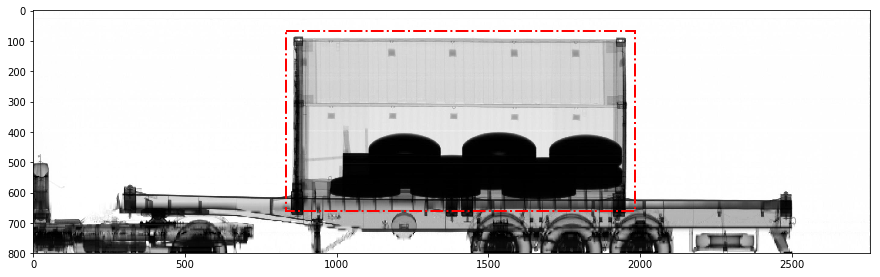

In [30]:
linha = random.choice(arquivos).split()
print(linha)
arquivo = linha[0]
xmin, ymin, xmax, ymax, classe = map(int, linha[1].split(','))
print(xmin, ymin, xmax, ymax)
image = Image.open(os.path.join('..', arquivo))
fig, ax = plt.subplots(1, figsize=(15, 12))
ax.imshow(image)
box = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                        fill=False, edgecolor='r',
                        linewidth=2, linestyle='dashdot')
ax.add_patch(box)

## Carregar e montar modelo

In [6]:
sys.path.append('../../keras-yolo3')

In [7]:
from yolo import YOLO

Using TensorFlow backend.


In [8]:
yolo = YOLO(
    model_path='../../keras-yolo3/logs/000/trained_weights_final.h5',
    anchors_path='../../keras-yolo3/model_data/yolo_anchors.txt',
    classes_path='../../keras-yolo3/model_data/container_classes.txt',
)


../../keras-yolo3/model_data/container_classes.txt
../../keras-yolo3/logs/000/trained_weights_final.h5 model, anchors, and classes loaded.


In [9]:
print([atrib for atrib in dir(yolo) if atrib[:2] !='__'])

['_defaults', '_get_anchors', '_get_class', 'anchors', 'anchors_path', 'boxes', 'class_names', 'classes', 'classes_path', 'close_session', 'colors', 'detect_image', 'generate', 'get_defaults', 'gpu_num', 'input_image_shape', 'iou', 'model_image_size', 'model_path', 'predict_image', 'score', 'scores', 'sess', 'yolo_model']


In [10]:
model = yolo.yolo_model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
zero_paddi

In [11]:
with open('../../yolo_weights/container_train.txt') as yolov3_in:
    arquivos = yolov3_in.readlines()

In [61]:
linha = random.choice(arquivos).split()
print(linha)
arquivo = linha[0]
xmin, ymin, xmax, ymax, classe = map(int, linha[1].split(','))
print(xmin, ymin, xmax, ymax)
image = Image.open(os.path.join('..', arquivo))

['../bases/yolo/5e67b03eae46c409aaec058b/5e67b03eae46c409aaec058b.jpg', '14,29,1550,680,0']
14 29 1550 680


In [62]:
xfinal, yfinal = image.size
print(xfinal, yfinal)
resized = image.resize(yolo.model_image_size, Image.LANCZOS)
print(resized.size)

1803 799
(416, 416)


In [63]:
out_boxes, out_scores, out_classes = yolo.predict_image(resized)

(416, 416, 3)
Found 1 boxes for img


In [64]:
print(out_boxes, out_scores, out_classes)

[[ 14.581707    4.3668528 353.55612   354.62195  ]] [0.99979526] [0]


In [65]:
xmin_pred, ymin_pred, xmax_pred, ymax_pred = out_boxes[0]
xmin_pred = int(xmin_pred * xfinal / 416)
xmax_pred = int(xmax_pred * xfinal / 416)
ymin_pred = int(ymin_pred * yfinal / 416)
ymax_pred = int(ymax_pred * yfinal / 416)
print(xmin_pred, ymin_pred, xmax_pred, ymax_pred)

63 8 1532 681


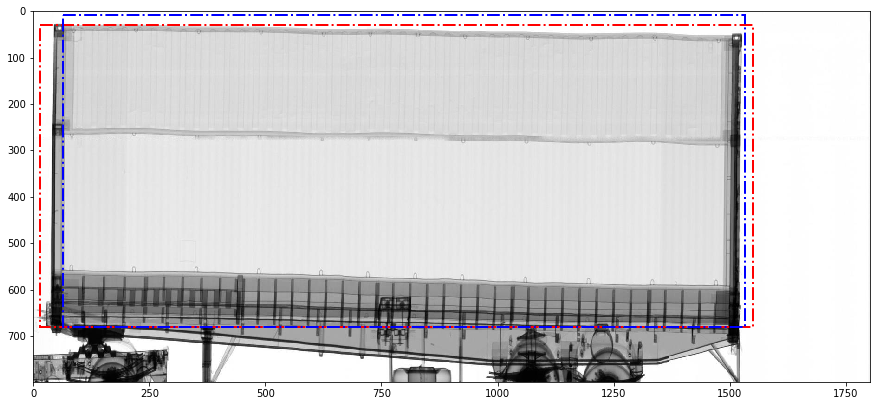

In [66]:
fig, ax = plt.subplots(1, figsize=(15, 12))
ax.imshow(image)
box = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                        fill=False, edgecolor='r',
                        linewidth=2, linestyle='dashdot')
ax.add_patch(box)
box = patches.Rectangle((xmin_pred, ymin_pred), xmax_pred - xmin_pred, ymax_pred - ymin_pred,
                        fill=False, edgecolor='b',
                        linewidth=2, linestyle='dashdot')
ax.add_patch(box)
